## Solve TSP with only PSO

Distance Matrix (Berlin52):
[[   0  666  281 ...  217  789 1220]
 [ 666    0  649 ...  596 1422 1716]
 [ 281  649    0 ...  463  995 1484]
 ...
 [ 217  596  463 ...    0  830 1151]
 [ 789 1422  995 ...  830    0  625]
 [1220 1716 1484 ... 1151  625    0]]


100%|██████████| 100/100 [00:04<00:00, 23.81it/s]


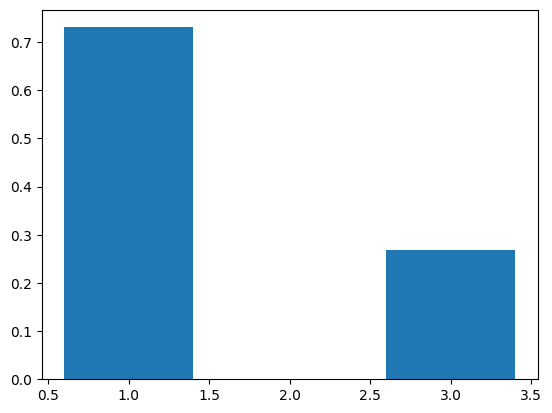

<Figure size 1000x600 with 0 Axes>

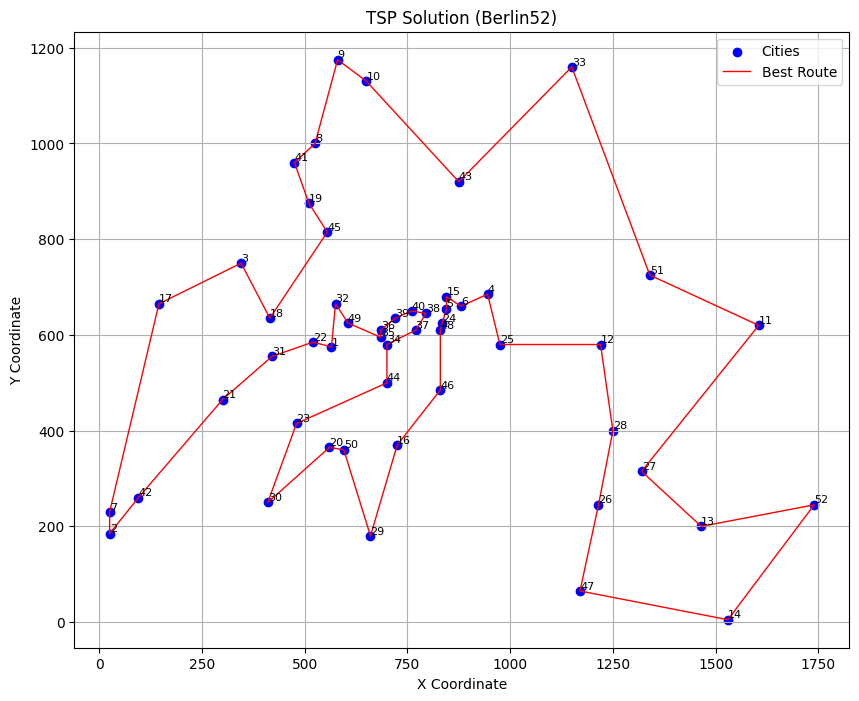

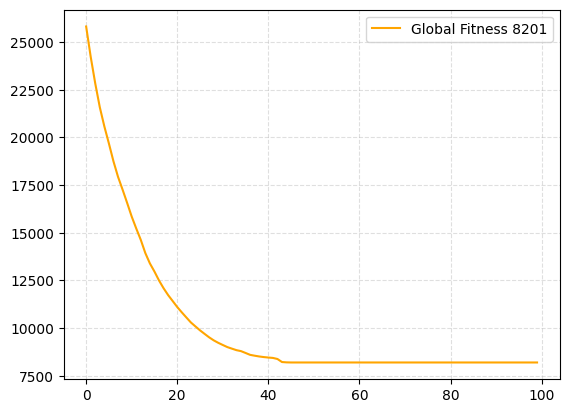


Best Route: [40, 18, 44, 17, 2, 16, 6, 1, 41, 20, 30, 21, 0, 31, 48, 34, 35, 38, 39, 37, 36, 33, 43, 22, 29, 19, 49, 28, 15, 45, 47, 23, 4, 14, 5, 3, 24, 11, 27, 25, 46, 13, 51, 12, 26, 10, 50, 32, 42, 9, 8, 7]
Best Distance: 8201


In [18]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm


class RLpredict(nn.Module):
    def __init__(self, input_dim):
        super(RLpredict, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# --- Helper Functions ---
def calculate_distance(route, distance_matrix):
    return sum(distance_matrix[route[i], route[(i + 1) % len(route)]] for i in range(len(route)))

def swap_operator(route1, route2):
    swaps = []
    for i in range(len(route1)):
        if route1[i] != route2[i]:
            j = route1.index(route2[i])
            swaps.append((i, j))
            route1[i], route1[j] = route1[j], route1[i]
    return swaps

def apply_swaps(route, swaps):
    new_route = route[:]
    for i, j in swaps:
        new_route[i], new_route[j] = new_route[j], new_route[i]
    return new_route

def crossover_elimination(route, distance_matrix):
    best_route = route[:]
    best_distance = calculate_distance(route, distance_matrix)
    for i in range(len(route) - 1):
        for j in range(i + 2, len(route)):
            new_route = route[:]
            new_route[i + 1:j + 1] = reversed(route[i + 1:j + 1])
            new_distance = calculate_distance(new_route, distance_matrix)
            if new_distance < best_distance:
                best_route, best_distance = new_route, new_distance
    return best_route

# --- PSO for TSP ---
def pso_tsp(distance_matrix, num_particles=10, max_iter=500, w=0.8, c1=1.5, c2=1.5):
    num_cities = len(distance_matrix)

    # Initialize particles (random permutations)
    particles = [np.random.permutation(num_cities).tolist() for _ in range(num_particles)]
    velocities = [[] for _ in range(num_particles)]

    # Evaluate fitness
    fitness = [calculate_distance(p, distance_matrix) for p in particles]

    # Best positions
    personal_best = particles[:]
    personal_best_fitness = fitness[:]
    global_best = particles[np.argmin(fitness)]
    global_best_fitness = min(fitness) 

    global_best_collector = []

    for _ in tqdm(range(max_iter)):
        for i in range(num_particles):

            
            # Update velocity (combine swap operations)
            v_personal = swap_operator(particles[i][:], personal_best[i][:])
            v_global = swap_operator(particles[i][:], global_best[:])
            
            random.seed(42)
            new_velocity = (
                random.sample(velocities[i], min(len(velocities[i]), int(w * len(velocities[i])))) +
                random.sample(v_personal, min(len(v_personal), int(c1 * len(v_personal)))) +
                random.sample(v_global, min(len(v_global), int(c2 * len(v_global))))
            )



            # Update particle
            velocities[i] = new_velocity
            particles[i] = apply_swaps(particles[i], velocities[i])

            # Apply Random swaps for random PSO
            # np.random.shuffle(particles[i])
            
            
            # Evaluate new fitness
            current_fitness = calculate_distance(particles[i], distance_matrix)

            # Update personal best
            if current_fitness < personal_best_fitness[i]:
                personal_best[i] = particles[i][:]
                personal_best_fitness[i] = current_fitness

            # Update global best
            if current_fitness < global_best_fitness:
                global_best = particles[i][:]
                global_best_fitness = current_fitness


        # Apply crossover elimination on the global best
        
        global_best = crossover_elimination(global_best, distance_matrix)
        global_best_fitness = calculate_distance(global_best, distance_matrix)
        global_best_collector.append(global_best_fitness)

    return global_best, global_best_fitness, global_best_collector





def calculate_distance_matrix(coords):
        num_nodes = len(coords)
        distance_matrix = np.zeros((num_nodes, num_nodes))
        
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j:
                    distance_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])
        return np.round(distance_matrix).astype(int)  # Round to nearest integer
    
    
    
    
def main():
    # np.random.seed(42)

    # Berlin52 Coordinates (node, x, y)
    coordinates = np.array([
        [565.0, 575.0], [25.0, 185.0], [345.0, 750.0], [945.0, 685.0], [845.0, 655.0],
        [880.0, 660.0], [25.0, 230.0], [525.0, 1000.0], [580.0, 1175.0], [650.0, 1130.0],
        [1605.0, 620.0], [1220.0, 580.0], [1465.0, 200.0], [1530.0, 5.0], [845.0, 680.0],
        [725.0, 370.0], [145.0, 665.0], [415.0, 635.0], [510.0, 875.0], [560.0, 365.0],
        [300.0, 465.0], [520.0, 585.0], [480.0, 415.0], [835.0, 625.0], [975.0, 580.0],
        [1215.0, 245.0], [1320.0, 315.0], [1250.0, 400.0], [660.0, 180.0], [410.0, 250.0],
        [420.0, 555.0], [575.0, 665.0], [1150.0, 1160.0], [700.0, 580.0], [685.0, 595.0],
        [685.0, 610.0], [770.0, 610.0], [795.0, 645.0], [720.0, 635.0], [760.0, 650.0],
        [475.0, 960.0], [95.0, 260.0], [875.0, 920.0], [700.0, 500.0], [555.0, 815.0],
        [830.0, 485.0], [1170.0, 65.0], [830.0, 610.0], [605.0, 625.0], [595.0, 360.0],
        [1340.0, 725.0], [1740.0, 245.0]
    ])

    # Function to compute the Euclidean distance matrix
    

    # Generate distance matrix
    distance_matrix = calculate_distance_matrix(coordinates)

    # Print the distance matrix
    print("Distance Matrix (Berlin52):")
    print(distance_matrix)


    max_iter = 100
    
    # Run PSO for TSP
    
    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    w, c1, c2 = softmax(np.array([np.random.randint(0, 10), np.random.randint(0, 10), np.random.randint(0, 10)]))
    # w, c1, c2 = 5.6027963747546125e-09, 5.6027963747546125e-09, 0.9999999887944072
    # print(w, c1, c2)
    best_route, best_distance, global_best_collector = pso_tsp(distance_matrix, max_iter=max_iter)
    plt.bar([1, 2, 3], [w, c1, c2])
    plt.show()
    plt.figure(figsize=(10, 6))
    
    best_route_sorted_x, best_route_sorted_y = [], []
    for i in best_route:
        best_route_sorted_x.append(coordinates[i][0])
        best_route_sorted_y.append(coordinates[i][1])
    best_route_sorted_x.append(best_route_sorted_x[0])
    best_route_sorted_y.append(best_route_sorted_y[0])
    plt.figure(figsize=(10, 8))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], c='blue', label="Cities")
    plt.plot(best_route_sorted_x, best_route_sorted_y, c='red', linestyle='-', linewidth=1, label="Best Route")
    for i, (x, y) in enumerate(coordinates):
        plt.text(x, y, str(i + 1), fontsize=8, verticalalignment='bottom')
    plt.title("TSP Solution (Berlin52)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

    
    plt.plot(global_best_collector, label=f"Global Fitness {best_distance}", color="orange")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.4)
    plt.show()
    
    print("\nBest Route:", best_route)
    print("Best Distance:", best_distance)
    
if __name__ == "__main__":
    main()


## First Trained Model

100%|██████████| 100/100 [00:04<00:00, 22.03it/s]


Best Route: [39, 38, 36, 45, 43, 33, 34, 35, 48, 31, 0, 21, 17, 30, 20, 22, 19, 49, 15, 28, 29, 41, 1, 6, 16, 2, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37]
Best Distance: 7760


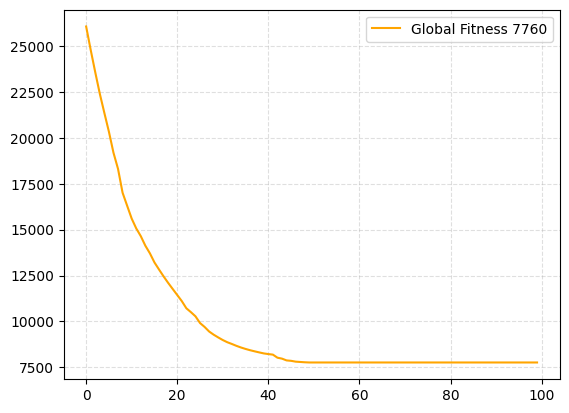

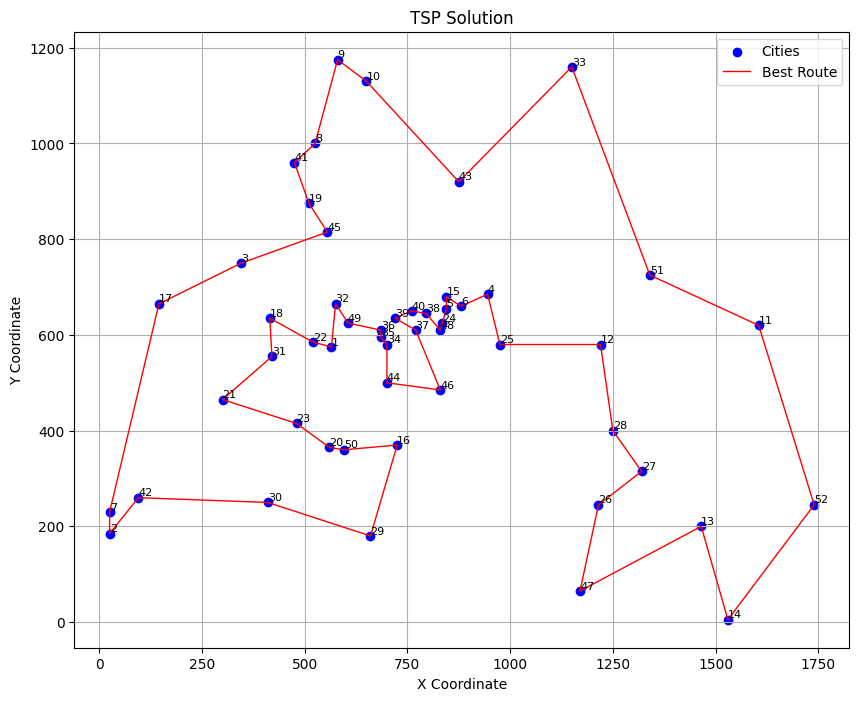

[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), ten

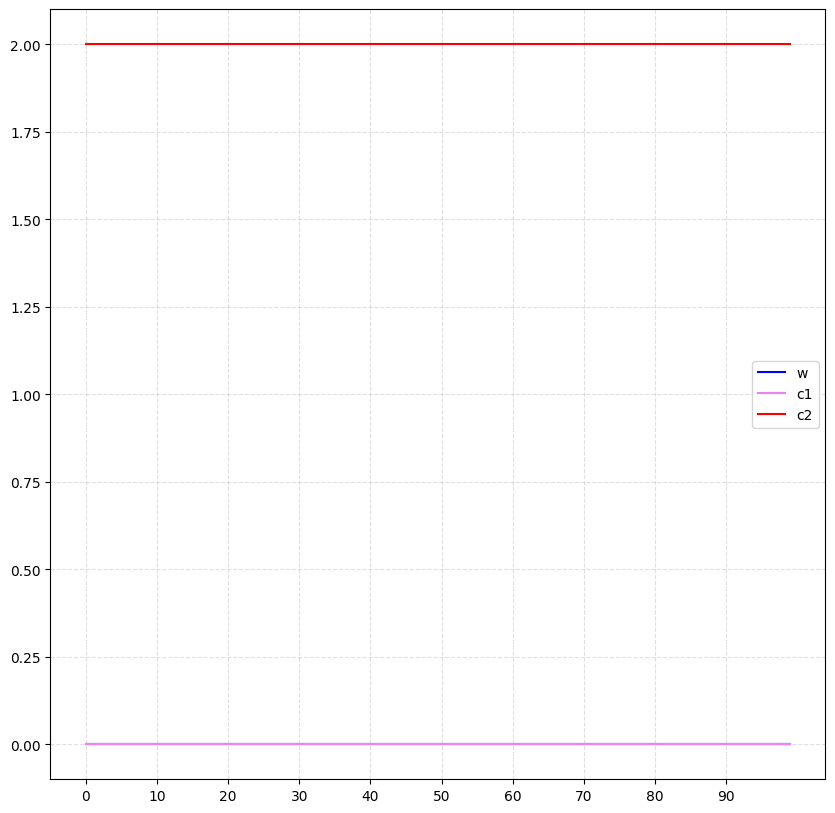

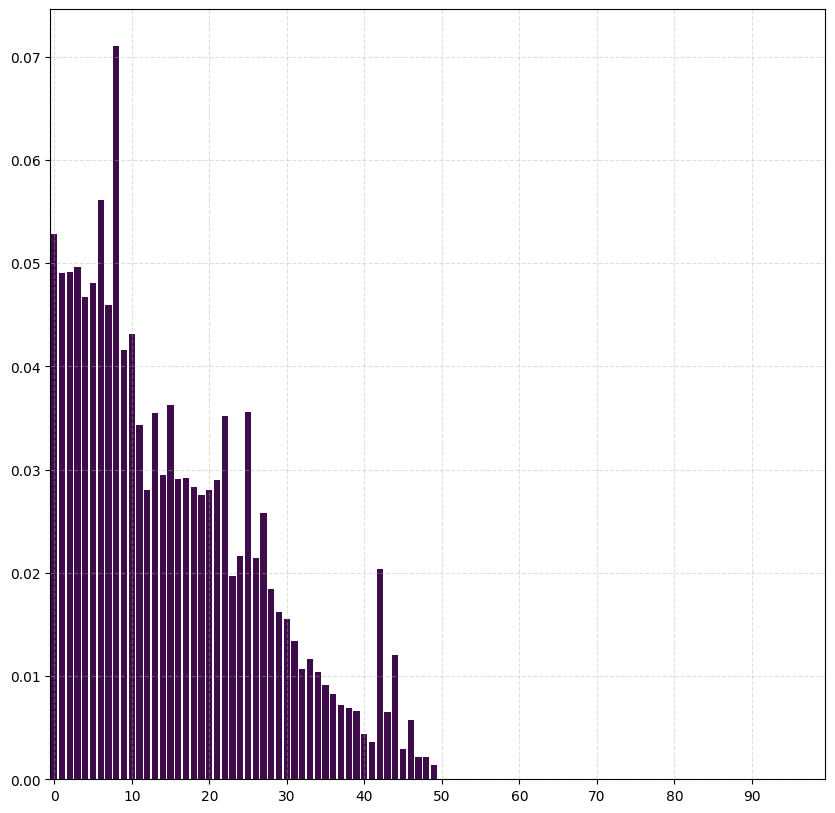

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.auto import tqdm

# Reinforcement Learning Model to predict PSO parameters
class RLpredict(nn.Module):
    def __init__(self, input_dim):
        super(RLpredict, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.w = nn.Linear(32, 1)
        self.c1 = nn.Linear(32, 1)
        self.c2 = nn.Linear(32, 1)

    def forward(self, x):
        hidden = self.model(x)
        w = torch.sigmoid(self.w(hidden))  # w between 0 and 1
        c1 = torch.sigmoid(self.c1(hidden)) * 2  # c1 between 0 and 2
        c2 = torch.sigmoid(self.c2(hidden)) * 2  # c2 between 0 and 2
        return w.squeeze(dim=0), c1.squeeze(dim=0), c2.squeeze(dim=0)

# Helper Functions
def calculate_distance(route, distance_matrix):
    return sum(distance_matrix[route[i], route[(i + 1) % len(route)]] for i in range(len(route)))

def swap_operator(route1, route2):
    swaps = []
    for i in range(len(route1)):
        if route1[i] != route2[i]:
            j = route1.index(route2[i])
            swaps.append((i, j))
            route1[i], route1[j] = route1[j], route1[i]
    return swaps

def apply_swaps(route, swaps):
    new_route = route[:]
    for i, j in swaps:
        new_route[i], new_route[j] = new_route[j], new_route[i]
    return new_route

def crossover_elimination(route, distance_matrix):
    best_route = route[:]
    best_distance = calculate_distance(route, distance_matrix)
    for i in range(len(route) - 1):
        for j in range(i + 2, len(route)):
            new_route = route[:]
            new_route[i + 1:j + 1] = reversed(route[i + 1:j + 1])
            new_distance = calculate_distance(new_route, distance_matrix)
            if new_distance < best_distance:
                best_route, best_distance = new_route, new_distance
    return best_route

def pso_tsp(distance_matrix, model, num_particles=10, max_iter=500):
    num_cities = len(distance_matrix)

    # Initialize particles
    particles = [np.random.permutation(num_cities).tolist() for _ in range(num_particles)]
    velocities = [[] for _ in range(num_particles)]

    fitness = [calculate_distance(p, distance_matrix) for p in particles]

    personal_best = particles[:]
    personal_best_fitness = fitness[:]
    global_best = particles[np.argmin(fitness)]
    global_best_fitness = min(fitness)
    prev_best_fitness = global_best_fitness

    global_best_collector = []
    reward_collector = []

    optimizer = optim.Adam(model.parameters(), lr=0.01)

    w_values, c1_values, c2_values = [], [], []

    for iteration in tqdm(range(max_iter)):
        # Input: Global best distance and current iteration
        model_input = torch.tensor([global_best_fitness, iteration / max_iter], dtype=torch.float32)
        w, c1, c2 = model(model_input)
        model.train()
        
        

        for i in range(num_particles):
            v_personal = swap_operator(particles[i][:], personal_best[i][:])
            v_global = swap_operator(particles[i][:], global_best[:])

            # random.seed(42)
            new_velocity = (
                random.sample(velocities[i], min(len(velocities[i]), int(w * len(velocities[i])))) +
                random.sample(v_personal, min(len(v_personal), int(c1 * len(v_personal)))) +
                random.sample(v_global, min(len(v_global), int(c2 * len(v_global))))
            )
            
            # new_velocity = (
            #     velocities[i][:min(len(velocities[i]), int(w * len(velocities[i])))] +
            #     v_personal[:min(len(v_personal), int(c1 * len(v_personal)))] +
            #     v_global[:min(len(v_global), int(c2 * len(v_global)))]
            # )

            velocities[i] = new_velocity
            particles[i] = apply_swaps(particles[i], velocities[i])

            current_fitness = calculate_distance(particles[i], distance_matrix)

            if current_fitness < personal_best_fitness[i]:
                personal_best[i] = particles[i][:]
                personal_best_fitness[i] = current_fitness

            if current_fitness < global_best_fitness:
                global_best = particles[i][:]
                global_best_fitness = current_fitness

        global_best = crossover_elimination(global_best, distance_matrix)
        global_best_fitness = calculate_distance(global_best, distance_matrix)
        global_best_collector.append(global_best_fitness)

        # Reward: Decrease in global best distance
        reward = (prev_best_fitness - global_best_fitness) / (prev_best_fitness + 1e-6)
        reward_collector.append(reward)
        prev_best_fitness = global_best_fitness

        optimizer.zero_grad()
        
        loss = -reward * (w + c1 + c2).mean()
        loss.backward()
        optimizer.step()
        
        w_values.append(w.detach())
        c1_values.append(c1.detach())
        c2_values.append(c2.detach())

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': max_iter,
        'loss': loss
    }
    torch.save(checkpoint, "Model/model_checkpoint.pth")

    return global_best, global_best_fitness, global_best_collector, w_values, c1_values, c2_values, reward_collector

def calculate_distance_matrix(coords):
    num_nodes = len(coords)
    distance_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])
    return np.round(distance_matrix).astype(int)

def main():
    coordinates = np.array([
        [565.0, 575.0], [25.0, 185.0], [345.0, 750.0], [945.0, 685.0], [845.0, 655.0],
        [880.0, 660.0], [25.0, 230.0], [525.0, 1000.0], [580.0, 1175.0], [650.0, 1130.0],
        [1605.0, 620.0], [1220.0, 580.0], [1465.0, 200.0], [1530.0, 5.0], [845.0, 680.0],
        [725.0, 370.0], [145.0, 665.0], [415.0, 635.0], [510.0, 875.0], [560.0, 365.0],
        [300.0, 465.0], [520.0, 585.0], [480.0, 415.0], [835.0, 625.0], [975.0, 580.0],
        [1215.0, 245.0], [1320.0, 315.0], [1250.0, 400.0], [660.0, 180.0], [410.0, 250.0],
        [420.0, 555.0], [575.0, 665.0], [1150.0, 1160.0], [700.0, 580.0], [685.0, 595.0],
        [685.0, 610.0], [770.0, 610.0], [795.0, 645.0], [720.0, 635.0], [760.0, 650.0],
        [475.0, 960.0], [95.0, 260.0], [875.0, 920.0], [700.0, 500.0], [555.0, 815.0],
        [830.0, 485.0], [1170.0, 65.0], [830.0, 610.0], [605.0, 625.0], [595.0, 360.0],
        [1340.0, 725.0], [1740.0, 245.0]
    ])
    
    
    distance_matrix = calculate_distance_matrix(coordinates)

    model = RLpredict(input_dim=2)
    max_iter=100
    
    best_route, best_distance, global_best_collector, w_values, c1_values, c2_values, rewards = pso_tsp(distance_matrix, model, max_iter=max_iter)

    print("Best Route:", best_route)
    print("Best Distance:", best_distance)

    
    plt.plot(global_best_collector, label=f"Global Fitness {best_distance}", color="orange")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.4)
    
    best_route_sorted_x, best_route_sorted_y = [], []
    for i in best_route:
        best_route_sorted_x.append(coordinates[i][0])
        best_route_sorted_y.append(coordinates[i][1])
    best_route_sorted_x.append(best_route_sorted_x[0])
    best_route_sorted_y.append(best_route_sorted_y[0])
    plt.figure(figsize=(10, 8))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], c='blue', label="Cities")
    plt.plot(best_route_sorted_x, best_route_sorted_y, c='red', linestyle='-', linewidth=1, label="Best Route")
    for i, (x, y) in enumerate(coordinates):
        plt.text(x, y, str(i + 1), fontsize=8, verticalalignment='bottom')
    plt.title("TSP Solution")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(w_values)
    plt.figure(figsize=(10, 10))
    sns.lineplot(x=range(max_iter), y=np.array(w_values), label="w", color="blue")
    sns.lineplot(x=range(max_iter), y=np.array(c1_values), label="c1", color="violet")
    sns.lineplot(x=range(max_iter), y=np.array(c2_values), label="c2", color="red")
    plt.xticks(range(0, max_iter, 10))
    plt.legend()
    plt.grid(linestyle="--", alpha=0.4)
    plt.show()
    
    plt.figure(figsize=(10, 10))
    sns.barplot(x=range(max_iter), y=rewards, palette="viridis", hue=y, legend=False)
    plt.xticks(range(0, max_iter, 10))
    plt.grid(linestyle="--", alpha=0.4)
    plt.show()

if __name__ == "__main__":
    main()


## Load Model For Fine Tuning

/tmp/ipykernel_7709/11060782.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("Model/model_checkpoint.pth")
  0%|          | 0/40 [00:00<?, ?it/s

Best Route: [0, 9, 8, 10, 7, 12, 6, 13, 11, 5, 4, 3, 2, 1]
Best Distance: 30


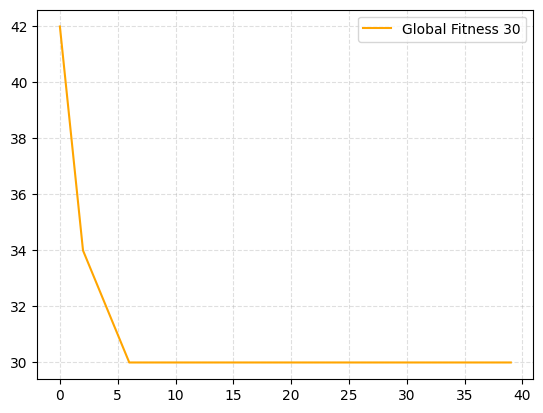

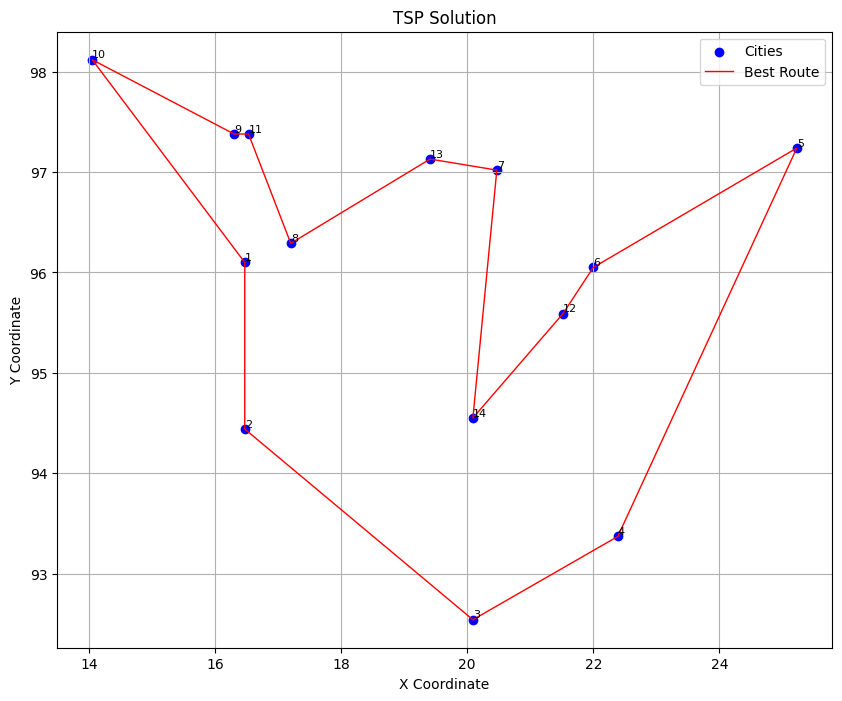

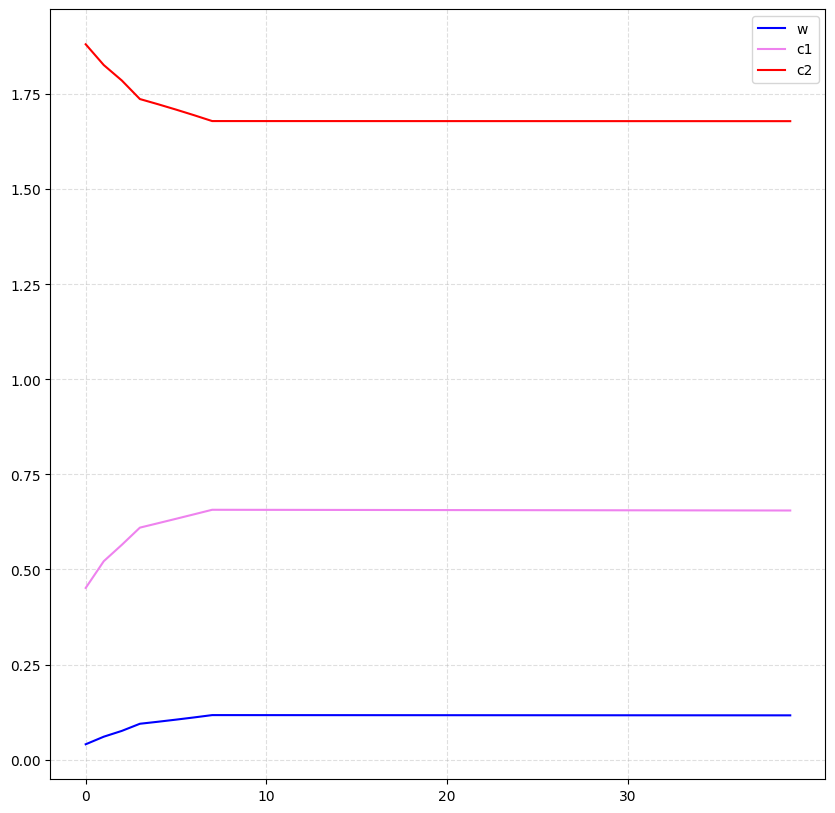

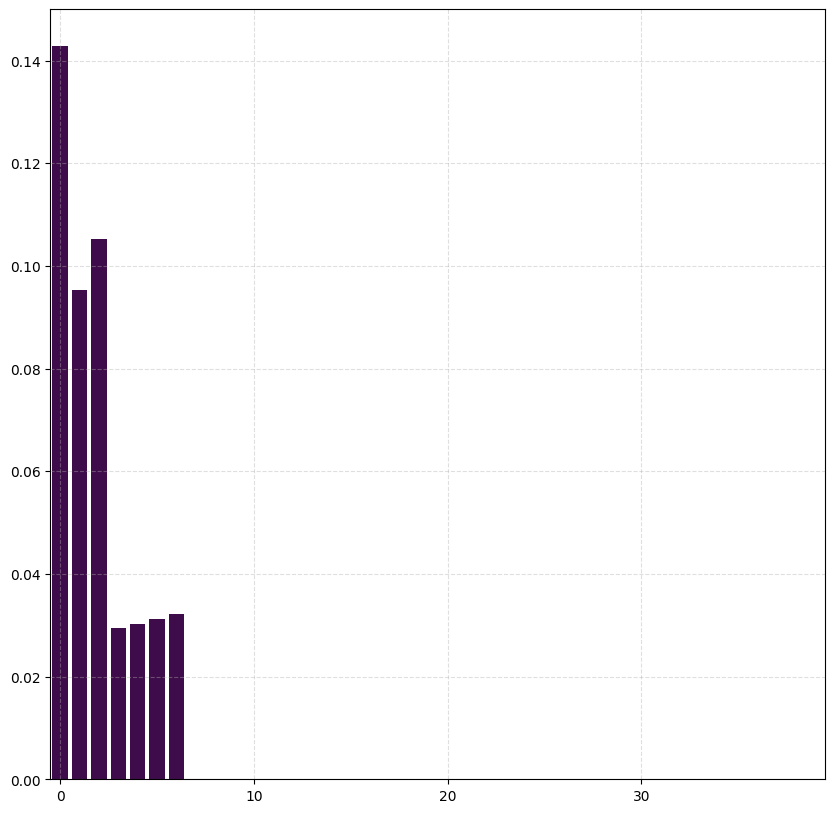

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.auto import tqdm

# Reinforcement Learning Model to predict PSO parameters
class RLpredict(nn.Module):
    def __init__(self, input_dim):
        super(RLpredict, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.w = nn.Linear(32, 1)
        self.c1 = nn.Linear(32, 1)
        self.c2 = nn.Linear(32, 1)

    def forward(self, x):
        hidden = self.model(x)
        w = torch.sigmoid(self.w(hidden))  # w between 0 and 1
        c1 = torch.sigmoid(self.c1(hidden)) * 2  # c1 between 0 and 2
        c2 = torch.sigmoid(self.c2(hidden)) * 2  # c2 between 0 and 2
        return w.squeeze(dim=0), c1.squeeze(dim=0), c2.squeeze(dim=0)

# Helper Functions
def calculate_distance(route, distance_matrix):
    return sum(distance_matrix[route[i], route[(i + 1) % len(route)]] for i in range(len(route)))

def swap_operator(route1, route2):
    swaps = []
    for i in range(len(route1)):
        if route1[i] != route2[i]:
            j = route1.index(route2[i])
            swaps.append((i, j))
            route1[i], route1[j] = route1[j], route1[i]
    return swaps

def apply_swaps(route, swaps):
    new_route = route[:]
    for i, j in swaps:
        new_route[i], new_route[j] = new_route[j], new_route[i]
    return new_route

def crossover_elimination(route, distance_matrix):
    best_route = route[:]
    best_distance = calculate_distance(route, distance_matrix)
    for i in range(len(route) - 1):
        for j in range(i + 2, len(route)):
            new_route = route[:]
            new_route[i + 1:j + 1] = reversed(route[i + 1:j + 1])
            new_distance = calculate_distance(new_route, distance_matrix)
            if new_distance < best_distance:
                best_route, best_distance = new_route, new_distance
    return best_route

def pso_tsp(distance_matrix, model, num_particles=10, max_iter=500, fine_tune_epochs=20):
    num_cities = len(distance_matrix)
    
    
    # Load Model
    checkpoint = torch.load("Model/model_checkpoint.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.005
    max_iter = checkpoint['epoch']
    loss = checkpoint['loss']
    epochs = fine_tune_epochs
    
    

    # Initialize particles
    particles = [np.random.permutation(num_cities).tolist() for _ in range(num_particles)]
    velocities = [[] for _ in range(num_particles)]

    fitness = [calculate_distance(p, distance_matrix) for p in particles]

    personal_best = particles[:]
    personal_best_fitness = fitness[:]
    global_best = particles[np.argmin(fitness)]
    global_best_fitness = min(fitness)
    prev_best_fitness = global_best_fitness
    
    
    global_best_collector = []
    reward_collector = []
    w_values, c1_values, c2_values = [], [], []

    for iteration in tqdm(range(max_iter, max_iter + epochs)):
        
        # Input: Global best distance and current iteration
        model_input = torch.tensor([global_best_fitness, iteration / max_iter], dtype=torch.float32)
        w, c1, c2 = model(model_input)
        model.train()
        
        

        for i in range(num_particles):
            v_personal = swap_operator(particles[i][:], personal_best[i][:])
            v_global = swap_operator(particles[i][:], global_best[:])

            # random.seed(42)
            new_velocity = (
                random.sample(velocities[i], min(len(velocities[i]), int(w * len(velocities[i])))) +
                random.sample(v_personal, min(len(v_personal), int(c1 * len(v_personal)))) +
                random.sample(v_global, min(len(v_global), int(c2 * len(v_global))))
            )

            velocities[i] = new_velocity
            particles[i] = apply_swaps(particles[i], velocities[i])

            current_fitness = calculate_distance(particles[i], distance_matrix)

            if current_fitness < personal_best_fitness[i]:
                personal_best[i] = particles[i][:]
                personal_best_fitness[i] = current_fitness

            if current_fitness < global_best_fitness:
                global_best = particles[i][:]
                global_best_fitness = current_fitness

        global_best = crossover_elimination(global_best, distance_matrix)
        global_best_fitness = calculate_distance(global_best, distance_matrix)
        global_best_collector.append(global_best_fitness)


        # Reward: Decrease in global best distance
        reward = (prev_best_fitness - global_best_fitness) / (prev_best_fitness + 1e-6)
        reward_collector.append(reward)
        prev_best_fitness = global_best_fitness
        optimizer.zero_grad()
        loss = torch.tensor(-reward * (w + c1 + c2).mean(), requires_grad=True)
        loss.backward()
        optimizer.step()
        
        w_values.append(w.detach())
        c1_values.append(c1.detach())
        c2_values.append(c2.detach())

    # Save Model
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': max_iter,
        'loss': loss
    }
    torch.save(checkpoint, "Model/model_checkpoint.pth")
    
    

    return global_best, global_best_fitness, global_best_collector, w_values, c1_values, c2_values, reward_collector

def calculate_distance_matrix(coords):
    num_nodes = len(coords)
    distance_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])
    return np.round(distance_matrix).astype(int)


def read_tsp_file(file_path):
    coordinates = []
    with open(file_path, 'r') as file:
        read_data = False
        for line in file.readlines():
            if line.startswith("NODE_COORD_SECTION"):
                read_data = True
                continue
            if line.startswith("EOF"):
                break
            if read_data:
                x, y = map(float, line.strip().split()[1:])
                coordinates.append([x, y])
    return coordinates


def main():
    file_paths = ["data/TSPLIB/burma14.tsp"]
    coordinates = np.array([
    [16.47, 96.10], [16.47, 94.44], [20.09, 92.54], [22.39, 93.37], 
    [25.23, 97.24], [22.00, 96.05], [20.47, 97.02], [17.20, 96.29], 
    [16.30, 97.38], [14.05, 98.12], [16.53, 97.38], [21.52, 95.59], 
    [19.41, 97.13], [20.09, 94.55]
    ])
    

    distance_matrix = calculate_distance_matrix(coordinates)

    model = RLpredict(input_dim=2)
    
    max_iter=100
    fine_tune_epochs=40
    
    best_route, best_distance, global_best_collector, w_values, c1_values, c2_values, rewards = pso_tsp(distance_matrix, model, max_iter=max_iter, fine_tune_epochs=fine_tune_epochs)

    print("Best Route:", best_route)
    print("Best Distance:", best_distance)

    
    plt.plot(global_best_collector, label=f"Global Fitness {best_distance}", color="orange")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.4)
    
    best_route_sorted_x, best_route_sorted_y = [], []
    for i in best_route:
        best_route_sorted_x.append(coordinates[i][0])
        best_route_sorted_y.append(coordinates[i][1])
    best_route_sorted_x.append(best_route_sorted_x[0])
    best_route_sorted_y.append(best_route_sorted_y[0])
    plt.figure(figsize=(10, 8))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], c='blue', label="Cities")
    plt.plot(best_route_sorted_x, best_route_sorted_y, c='red', linestyle='-', linewidth=1, label="Best Route")
    for i, (x, y) in enumerate(coordinates):
        plt.text(x, y, str(i + 1), fontsize=8, verticalalignment='bottom')
    plt.title("TSP Solution")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 10))
    sns.lineplot(x=range(fine_tune_epochs), y=np.array(w_values), label="w", color="blue")
    sns.lineplot(x=range(fine_tune_epochs), y=np.array(c1_values), label="c1", color="violet")
    sns.lineplot(x=range(fine_tune_epochs), y=np.array(c2_values), label="c2", color="red")
    plt.xticks(range(0, fine_tune_epochs, 10))
    plt.legend()
    plt.grid(linestyle="--", alpha=0.4)
    plt.show()
    
    plt.figure(figsize=(10, 10))
    sns.barplot(x=range(fine_tune_epochs), y=rewards, palette="viridis", hue=y, legend=False)
    plt.xticks(range(0, fine_tune_epochs, 10))
    plt.grid(linestyle="--", alpha=0.4)
    plt.show()

if __name__ == "__main__":
    main()
